
# Detecting Distracted Drivers on the road

In [0]:
# We need pillow version of 5.3.0
# We will uninstall the older version first
#!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

    100% |████████████████████████████████| 2.0MB 16.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


4.0.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 484.0MB 52.5MB/s 
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
  Found existing installation: torch 1.0.0
    Uninstalling torch-1.0.0:
      Successfully uninstalled torch-1.0.0


# **Installing and importing libraries**

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from torch.utils import data
import random

cuda:0


# Getting the dataset

In [0]:
!gdown https://drive.google.com/uc?id=1GAuEzYChHy3TsZr0BLsAX9A3se37isGW
!unzip -qq drivers.zip
#You can get the original dataset here:
#https://www.kaggle.com/c/state-farm-distracted-driver-detection

Downloading...
From: https://drive.google.com/uc?id=1GAuEzYChHy3TsZr0BLsAX9A3se37isGW
To: /content/drivers.zip
971MB [00:06, 144MB/s]


In [0]:
data_dir = '/drivers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 64
use_gpu = torch.cuda.is_available()

In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import json

with open('cate.json', 'r') as f:
    cat_to_name = json.load(f)
    

# Defining transforms, data augmentation and normalization for training

In [0]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = 'drivers'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}


class_names= image_datasets['train'].classes

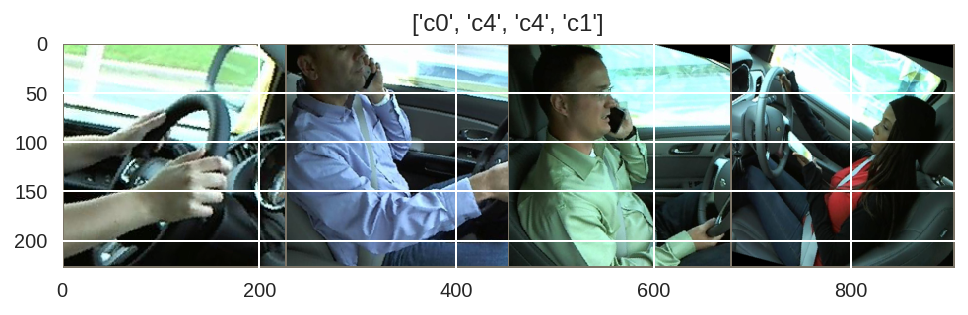

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(8, 8))
imshow(out, title=[class_names[x] for x in classes])

# Installing Pre-trained model Resnet-152

In [0]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Building and training the network

In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

# our input_size matches the in_features of pretrained model


from collections import OrderedDict


# creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))



# replacing the pretrained model classifier with our classifier
model.fc = classifier

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#Train a model with a pre-trained network
num_epochs = 20
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.CrossEntropyLoss()

 #Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=.0001)
#optimizer = optim.SGD(model.fc.parameters(), lr = .1, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.55)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Using GPU: True
Epoch 1/20
----------
train Loss: 2.0401 Acc: 0.2834
valid Loss: 1.3613 Acc: 0.5870

Epoch 2/20
----------
train Loss: 1.7094 Acc: 0.4191
valid Loss: 1.1088 Acc: 0.6030

Epoch 3/20
----------
train Loss: 1.6005 Acc: 0.4548
valid Loss: 0.9760 Acc: 0.6790

Epoch 4/20
----------
train Loss: 1.5403 Acc: 0.4777
valid Loss: 0.9344 Acc: 0.6790

Epoch 5/20
----------
train Loss: 1.5005 Acc: 0.4905
valid Loss: 0.8966 Acc: 0.7010

Epoch 6/20
----------
train Loss: 1.4423 Acc: 0.5132
valid Loss: 0.7450 Acc: 0.7690

Epoch 7/20
----------
train Loss: 1.4326 Acc: 0.5141
valid Loss: 0.7790 Acc: 0.7540

Epoch 8/20
----------
train Loss: 1.4014 Acc: 0.5258
valid Loss: 0.6794 Acc: 0.7780

Epoch 9/20
----------
train Loss: 1.3847 Acc: 0.5307
valid Loss: 0.7749 Acc: 0.7480

Epoch 10/20
----------
train Loss: 1.3765 Acc: 0.5368
valid Loss: 0.6494 Acc: 0.7910

Epoch 11/20
----------
train Loss: 1.3447 Acc: 0.5450
valid Loss: 0.7072 Acc: 0.7610

Epoch 12/20
----------
train Loss: 1.3305 Acc: 

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

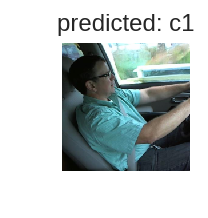

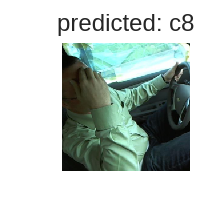

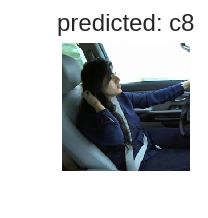

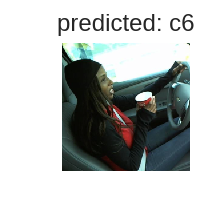

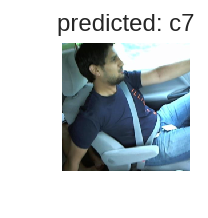

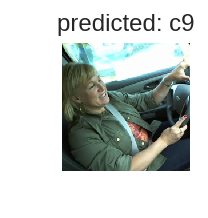

In [0]:
visualize_model(model_ft)

In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

In [0]:
test(model, dataloaders, device)

Testing Accuracy: 0.003
Testing Accuracy: 0.007
Testing Accuracy: 0.010
Testing Accuracy: 0.014
Testing Accuracy: 0.017
Testing Accuracy: 0.020
Testing Accuracy: 0.024
Testing Accuracy: 0.028
Testing Accuracy: 0.032
Testing Accuracy: 0.036
Testing Accuracy: 0.040
Testing Accuracy: 0.043
Testing Accuracy: 0.047
Testing Accuracy: 0.050
Testing Accuracy: 0.054
Testing Accuracy: 0.058
Testing Accuracy: 0.062
Testing Accuracy: 0.065
Testing Accuracy: 0.068
Testing Accuracy: 0.070
Testing Accuracy: 0.074
Testing Accuracy: 0.078
Testing Accuracy: 0.080
Testing Accuracy: 0.081
Testing Accuracy: 0.084
Testing Accuracy: 0.087
Testing Accuracy: 0.091
Testing Accuracy: 0.094
Testing Accuracy: 0.097
Testing Accuracy: 0.100
Testing Accuracy: 0.104
Testing Accuracy: 0.107
Testing Accuracy: 0.108
Testing Accuracy: 0.111
Testing Accuracy: 0.115
Testing Accuracy: 0.119
Testing Accuracy: 0.123
Testing Accuracy: 0.126
Testing Accuracy: 0.129
Testing Accuracy: 0.132
Testing Accuracy: 0.135
Testing Accuracy

In [0]:
# Save the checkpoint 


model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size':10,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'driver82_checkpoint.pth')

In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 10
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


    # replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('driver82_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 361, 361
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Predictions

In [0]:
def predict(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    probabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(probabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = probabilities[top_idx]

    return top_probability, top_class

In [0]:
print (predict('drivers/valid/c1/img_100021.jpg', loaded_model))

(array([0.57686   , 0.18516962, 0.13634731], dtype=float32), ['c1', 'c9', 'c0'])


In [0]:
# Display an image along with the top 3 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(7,11), ncols=1, nrows=2)
    driver_type = mapper[img_filename]
    
    ax1.set_title(driver_type)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

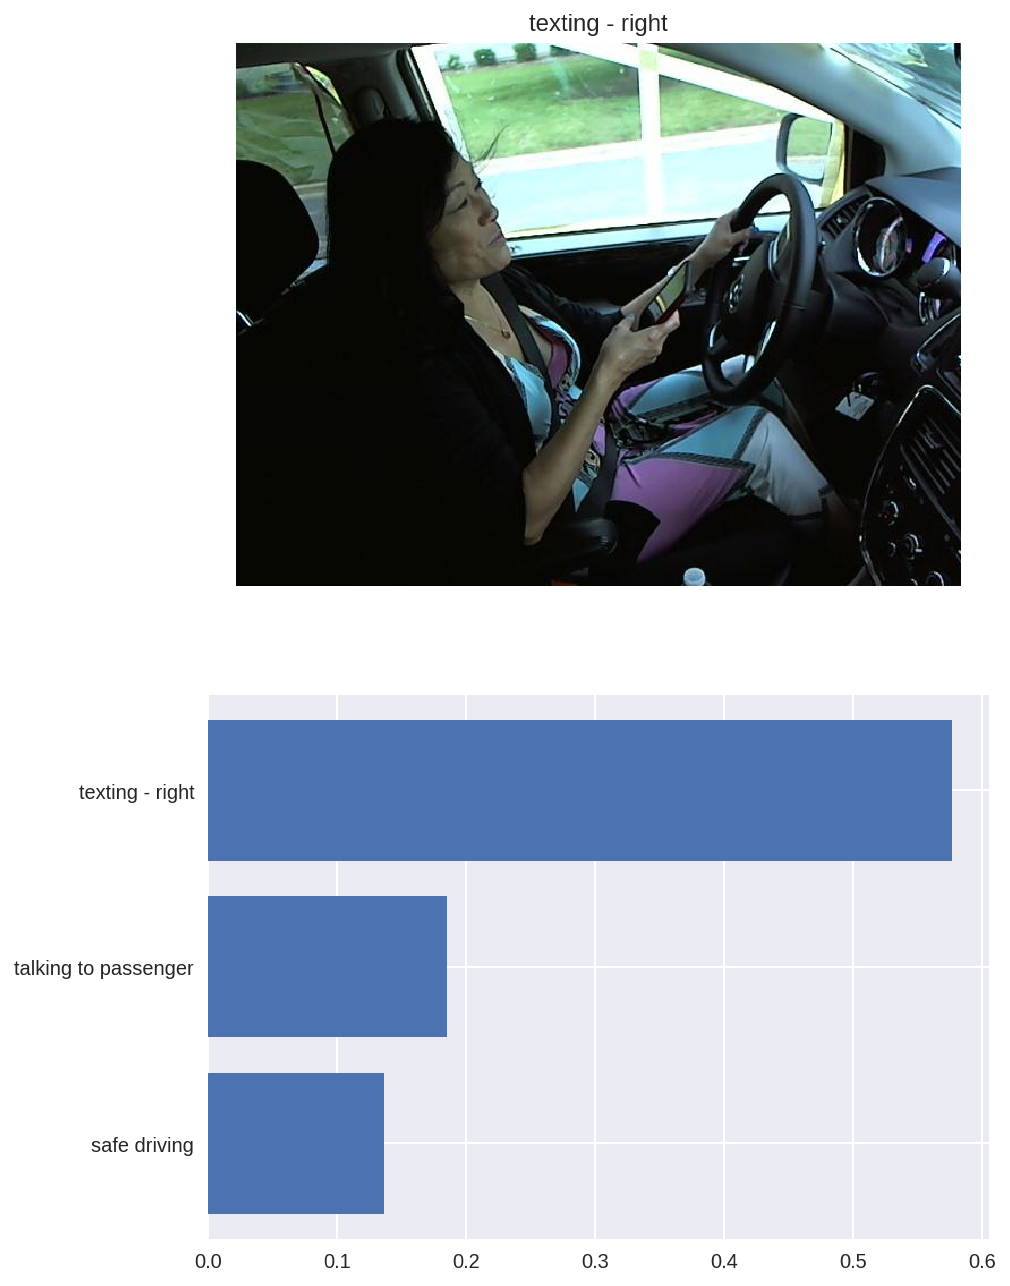

In [0]:
img ='drivers/valid/c1/img_100021.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

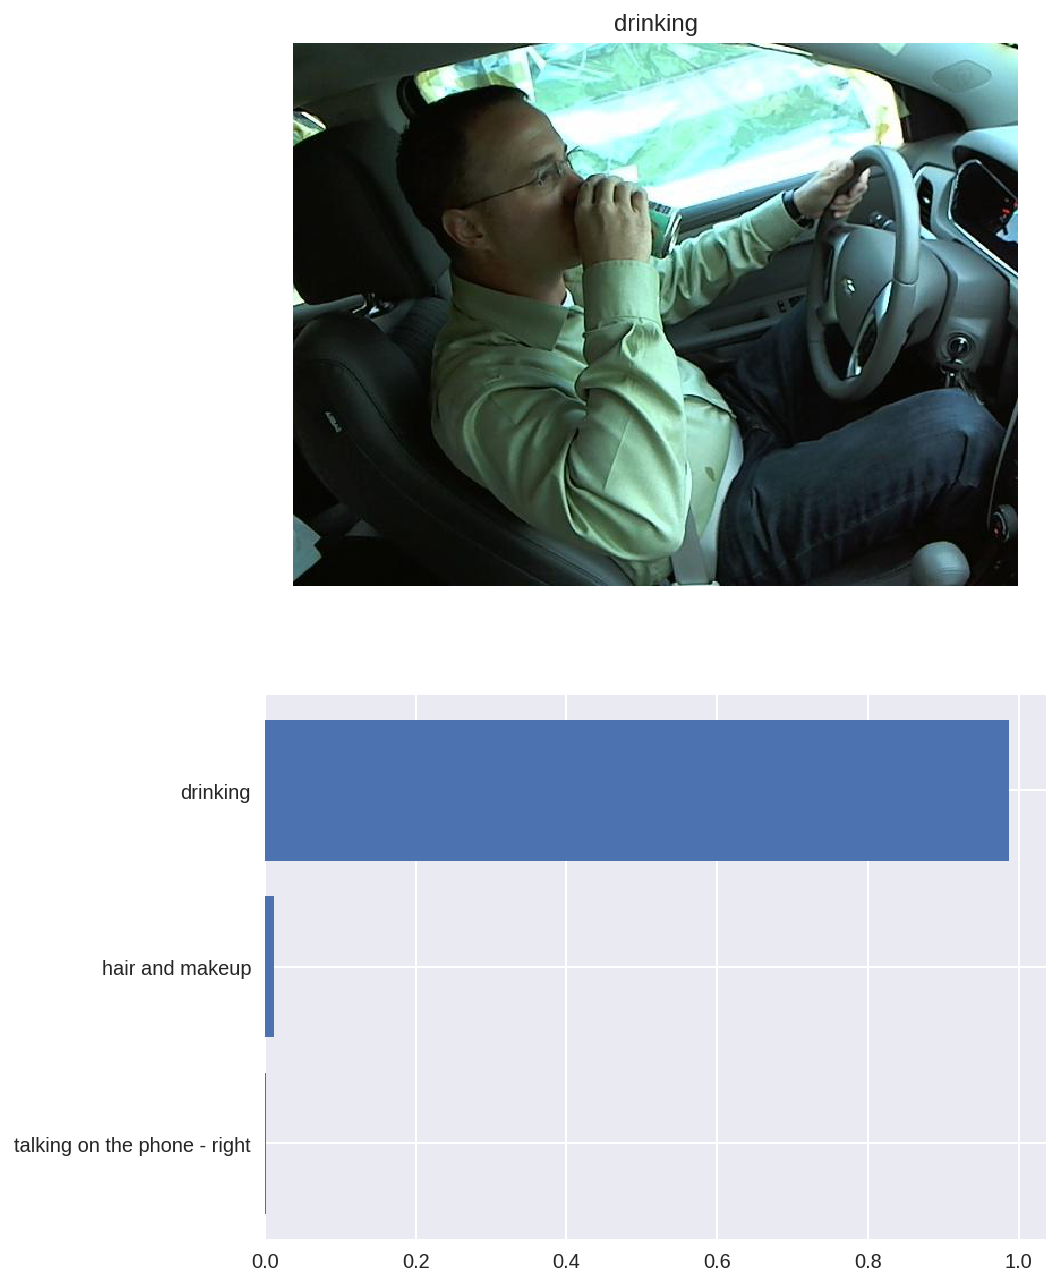

In [0]:
img ='drivers/valid/c6/img_100036.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

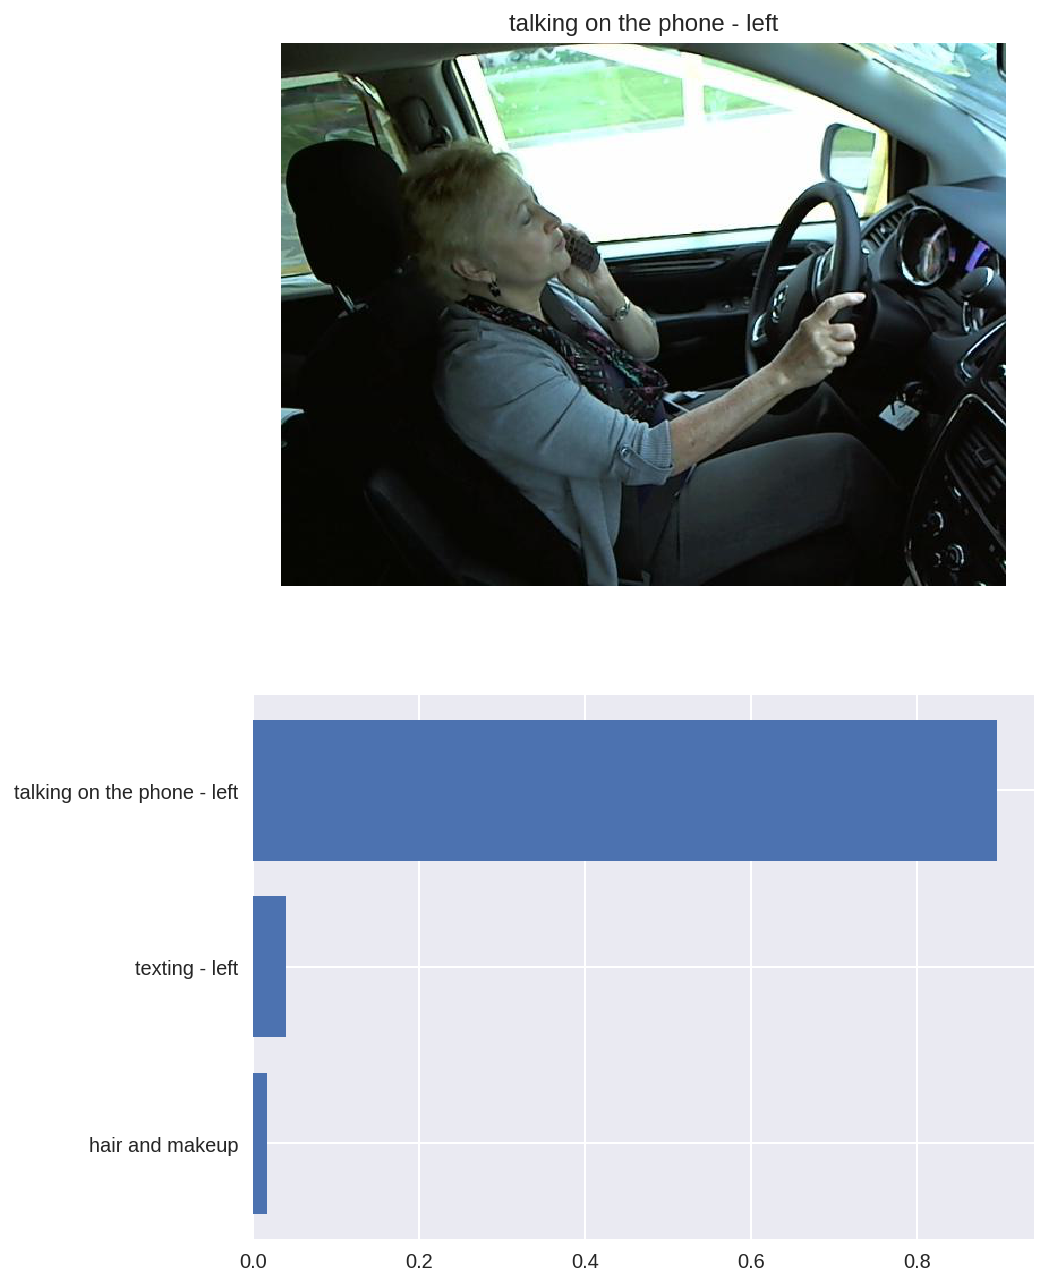

In [0]:
img ='drivers/valid/c4/img_100225.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

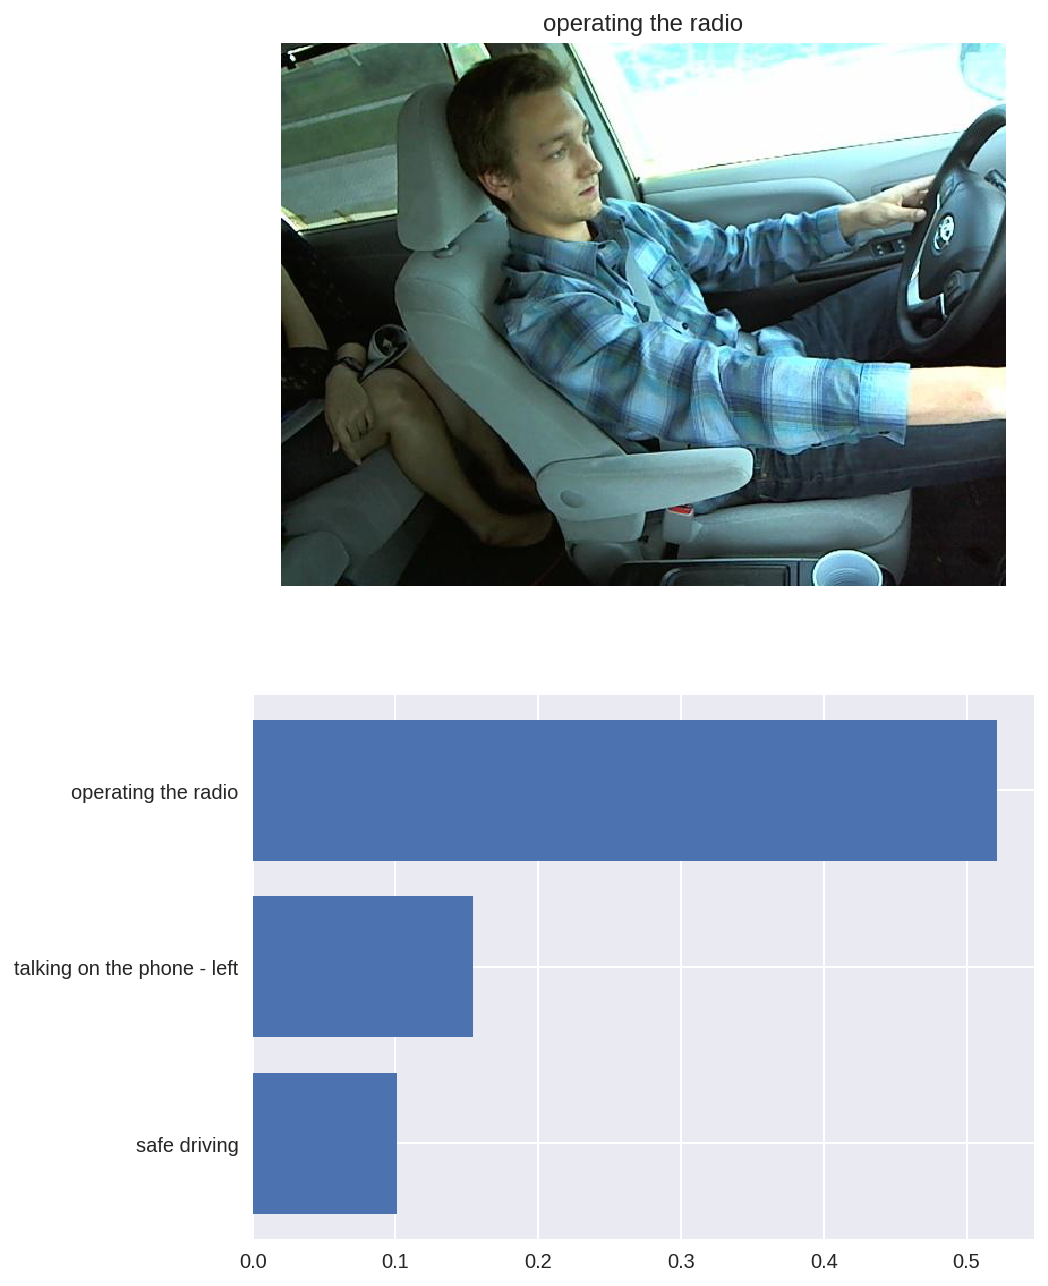

In [0]:
img ='drivers/valid/c5/img_100027.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

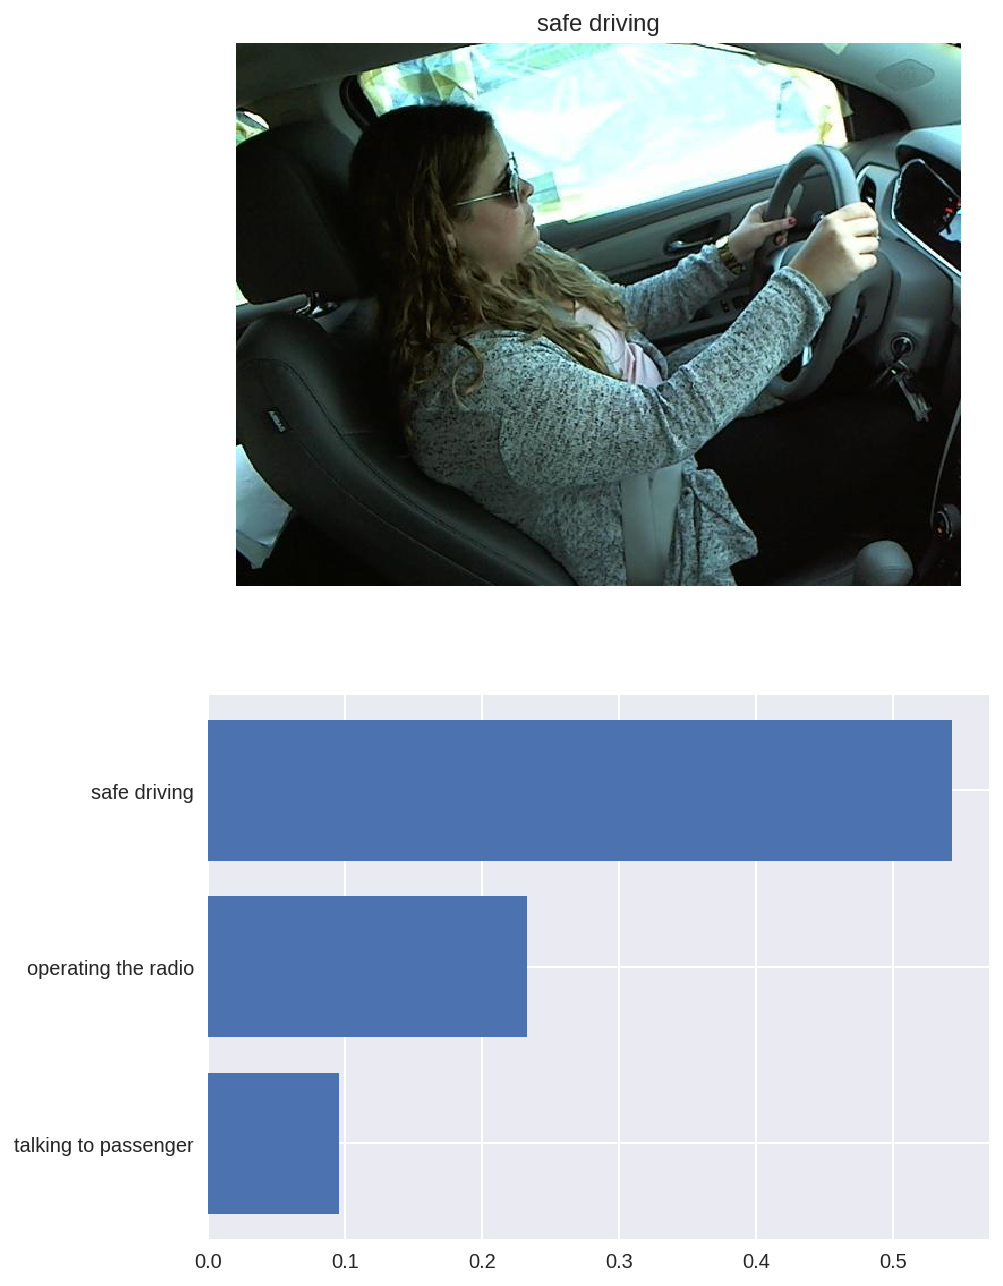

In [0]:
img ='drivers/valid/c0/img_101015.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

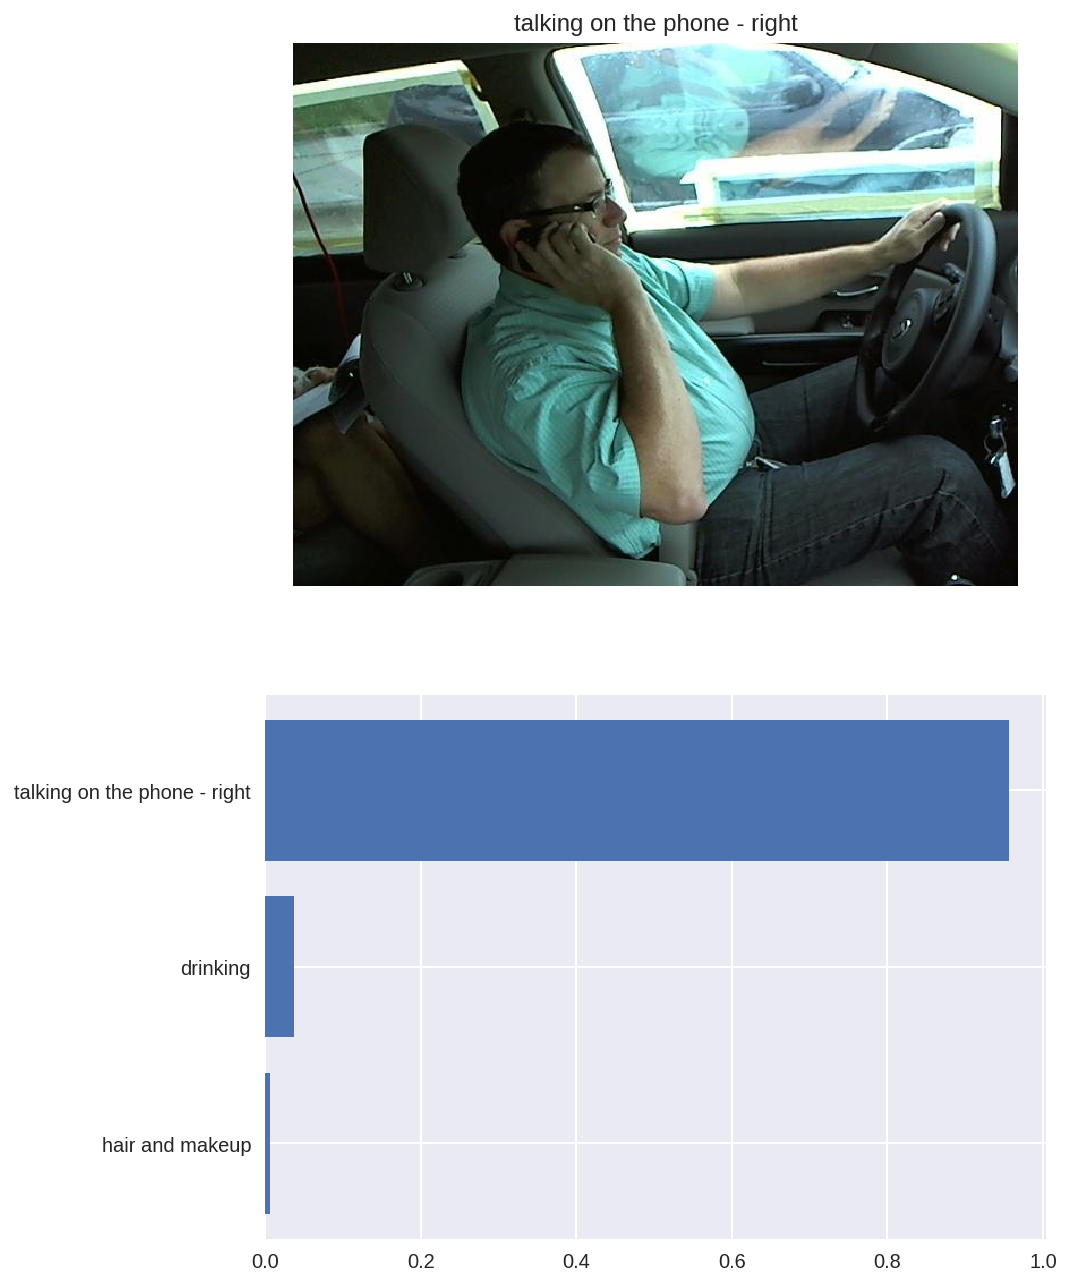

In [0]:
img ='drivers/valid/c2/img_100029.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

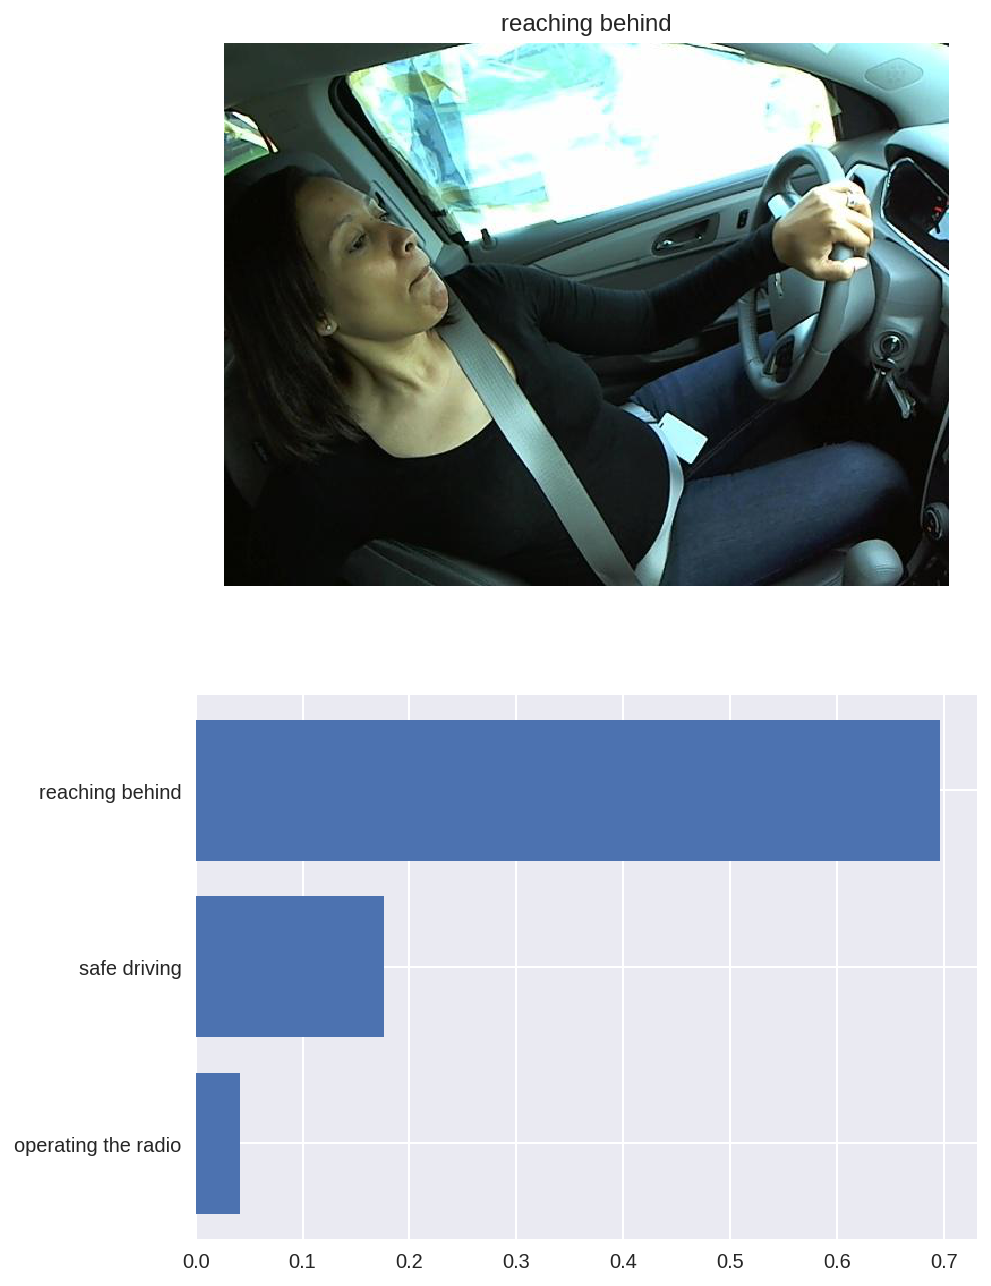

In [0]:
img ='drivers/valid/c7/img_99997.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

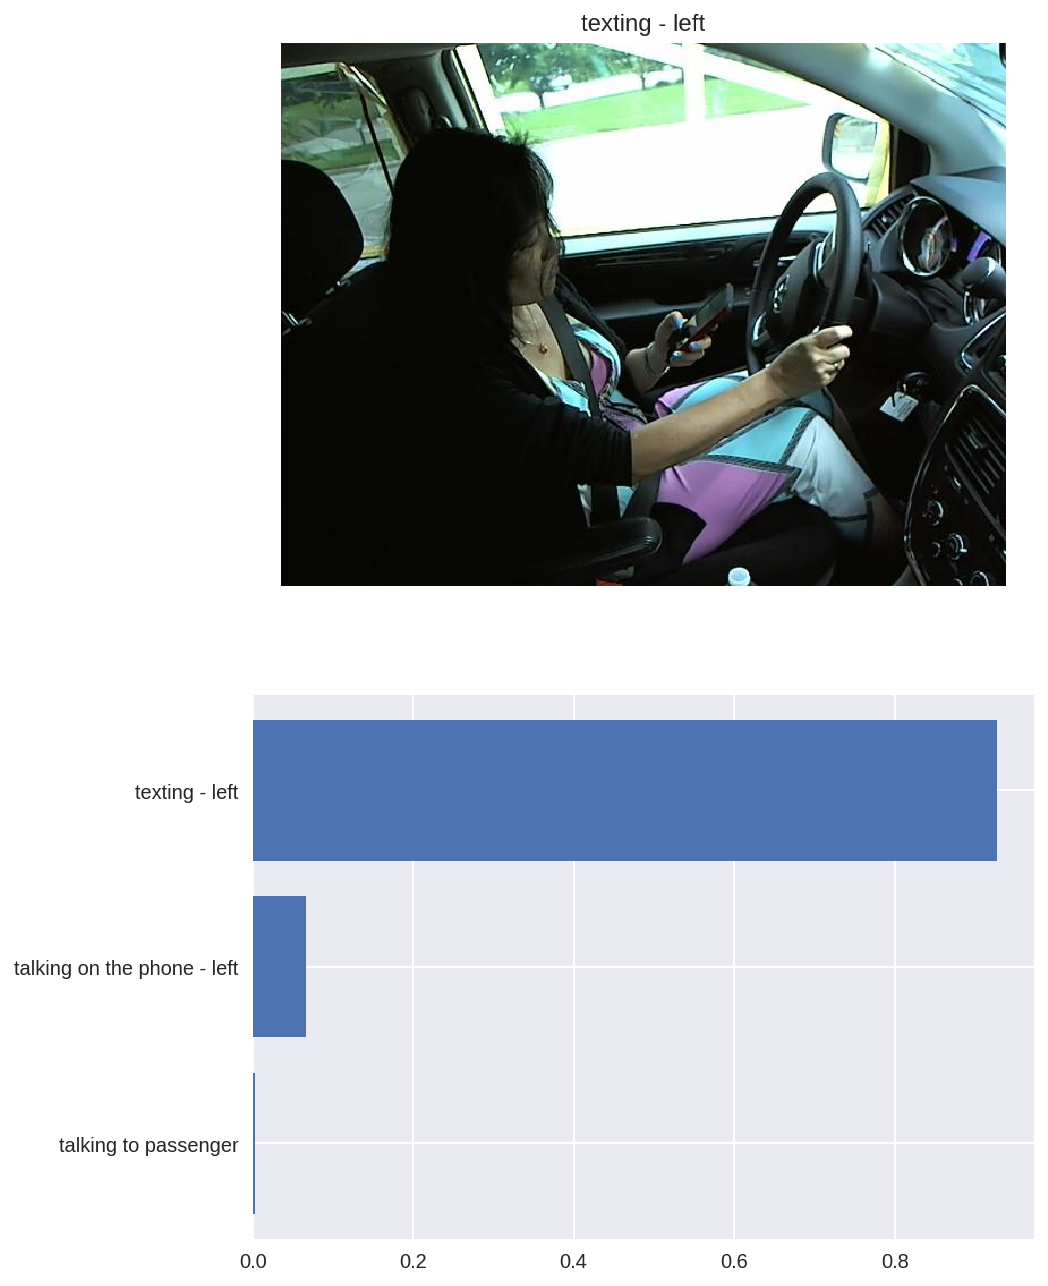

In [0]:
img ='drivers/valid/c3/img_100006.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

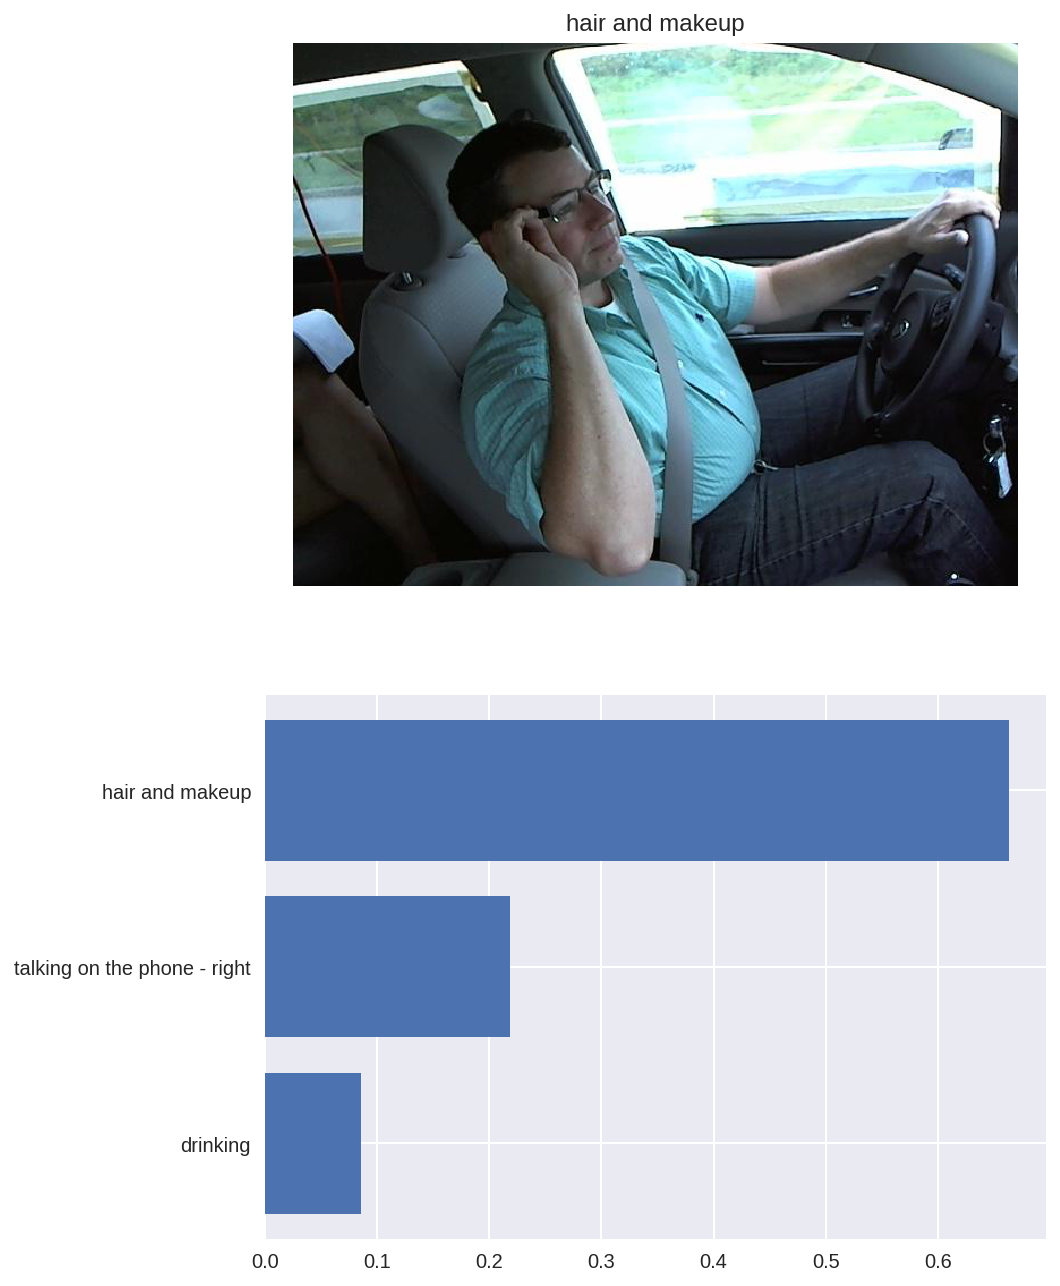

In [0]:
img ='drivers/valid/c8/img_101229.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

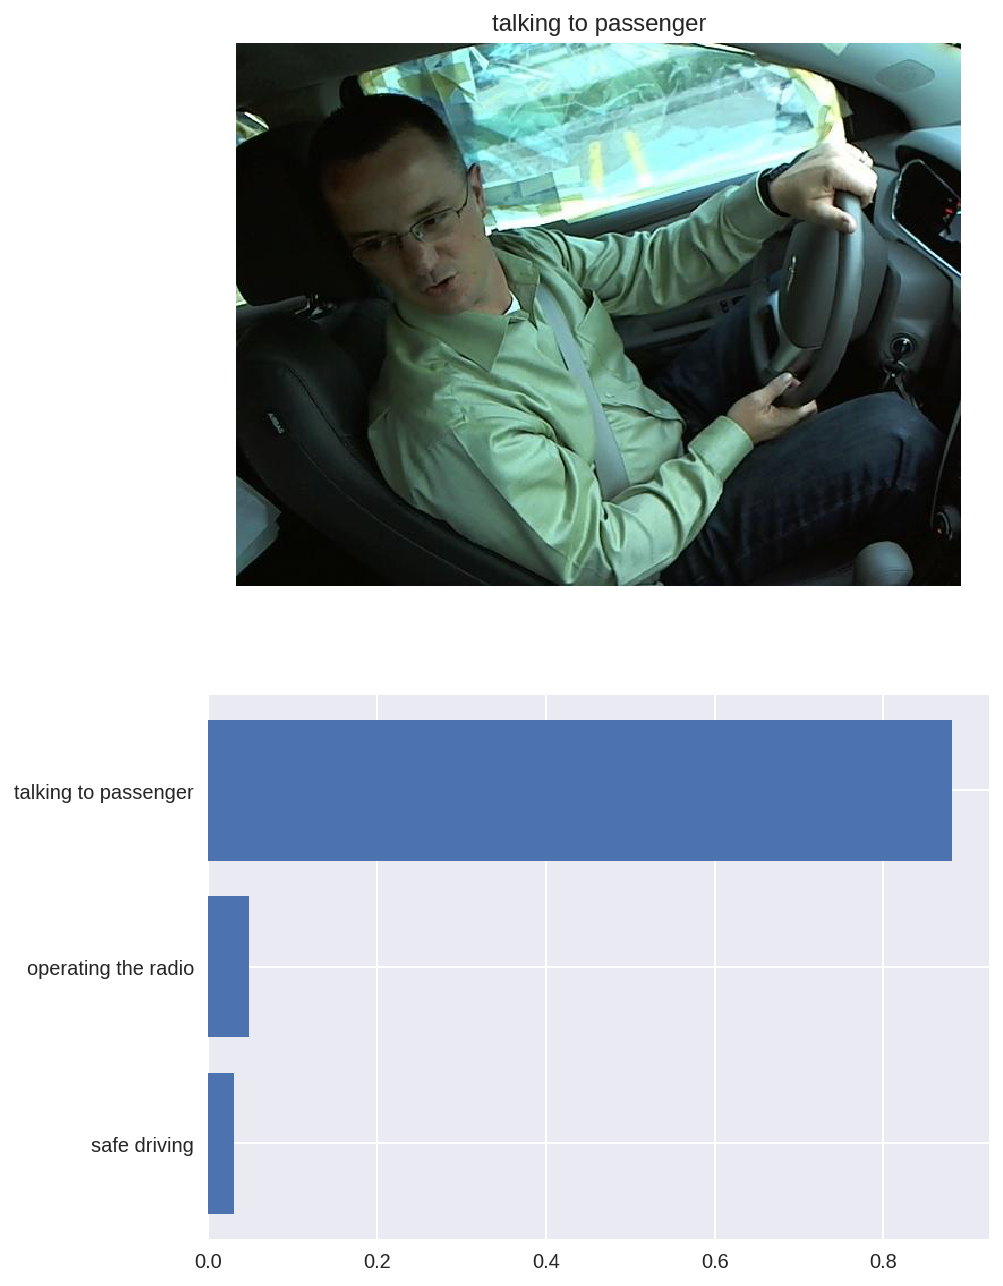

In [0]:
img ='drivers/valid/c9/img_100090.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)